# Data Analytics for Health - Task 2.1: K-means Clustering Analysis

## Overview
This notebook performs K-means clustering analysis on the prepared patient profile:
- 2.1.1: Identification of the best value of k
- 2.1.2: Characterization of the obtained clusters (centroid analysis and distribution comparison)
- 2.1.3: Evaluation of the clustering results

## Objectives
- Determine optimal number of clusters using elbow method, silhouette analysis, etc.
- Analyze cluster characteristics through centroids and variable distributions
- Evaluate clustering quality using appropriate metrics

---


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data
Plots directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/plots


## 1. Load Prepared Patient Profile


In [2]:
# Load prepared patient profile
df = pd.read_csv(data_path / '1.2.2_prepared_patient_profile.csv')

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# Prepare data for clustering
X = df[numeric_features].copy()
subject_ids = df['subject_id'].copy()

# Handle any remaining NaN values
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())  # Fill with mean or use appropriate strategy
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")


Loaded patient profile: 4,392 subjects × 14 features

Columns: ['subject_id', 'n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 'n_positive_micro', 'abnormal_ratio', 'max_glucose', 'mean_creatinine', 'mean_hemoglobin', 'age', 'days_since_last_admission_x', 'n_total_admissions', 'gender']

Numeric features for clustering: 12
Features: ['n_lab_events', 'n_micro_exam', 'total_procedures', 'n_diagnoses', 'n_positive_micro', 'abnormal_ratio', 'max_glucose', 'mean_creatinine', 'mean_hemoglobin', 'age', 'days_since_last_admission_x', 'n_total_admissions']

NaN values before handling: 4001
NaN values after handling: 0

Data prepared for clustering: (4392, 12)


## 2.1.1 Identification of the Best Value of k


In [3]:
# Test different values of k
k_range = range(2, 11)  # Test k from 2 to 10
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Testing different values of k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, "
          f"DB={davies_bouldin_scores[-1]:.3f}, CH={calinski_harabasz_scores[-1]:.2f}")

# Store results
k_evaluation = pd.DataFrame({
    'k': list(k_range),
    'inertia': inertias,
    'silhouette': silhouette_scores,
    'davies_bouldin': davies_bouldin_scores,
    'calinski_harabasz': calinski_harabasz_scores
})




Testing different values of k...
k=2: Inertia=40461.79, Silhouette=0.454, DB=1.634, CH=851.73
k=3: Inertia=35065.85, Silhouette=0.197, DB=1.828, CH=828.98
k=4: Inertia=31867.11, Silhouette=0.213, DB=1.581, CH=754.81
k=5: Inertia=28946.19, Silhouette=0.164, DB=1.612, CH=733.76
k=6: Inertia=26291.75, Silhouette=0.177, DB=1.490, CH=734.69
k=7: Inertia=24252.27, Silhouette=0.189, DB=1.369, CH=725.03
k=8: Inertia=22981.08, Silhouette=0.193, DB=1.364, CH=690.32
k=9: Inertia=21545.79, Silhouette=0.187, DB=1.356, CH=680.62
k=10: Inertia=20471.24, Silhouette=0.197, DB=1.329, CH=662.17


### Understanding Silhouette Plots

**What is a Silhouette Plot?**
A silhouette plot visualizes how well each data point fits into its assigned cluster. The silhouette coefficient ranges from **-1 to +1**:
- **+1**: Point is well-matched to its cluster and poorly matched to neighboring clusters (ideal)
- **0**: Point is on the boundary between two clusters (ambiguous)
- **-1**: Point is poorly matched to its cluster and better matched to a neighboring cluster (misclassified)

**What to Look For:**

1. **Average Silhouette Score (Red Dashed Line)**
   - Higher is better (closer to +1)
   - Values > 0.5 indicate good clustering structure
   - Values 0.3-0.5 indicate fair clustering
   - Values < 0.3 suggest poor clustering

2. **Cluster Width and Shape**
   - **Wide bars**: Most points in the cluster have high silhouette scores (good cohesion)
   - **Narrow bars**: Points have varying silhouette scores (less cohesive)
   - **Uniform width**: All clusters are similarly well-defined

3. **Cluster Heights**
   - Height represents the number of points in each cluster
   - Similar heights indicate balanced cluster sizes
   - Very different heights may indicate imbalanced clusters

4. **Negative Values**
   - Points with negative silhouette scores are closer to other clusters than their own
   - Many negative values suggest poor cluster separation
   - Ideally, all bars should be to the right of 0

5. **Comparing Different k Values**
   - Choose the k with the highest average silhouette score
   - Prefer k values where all clusters have mostly positive scores
   - Avoid k values with many negative scores or very low averages


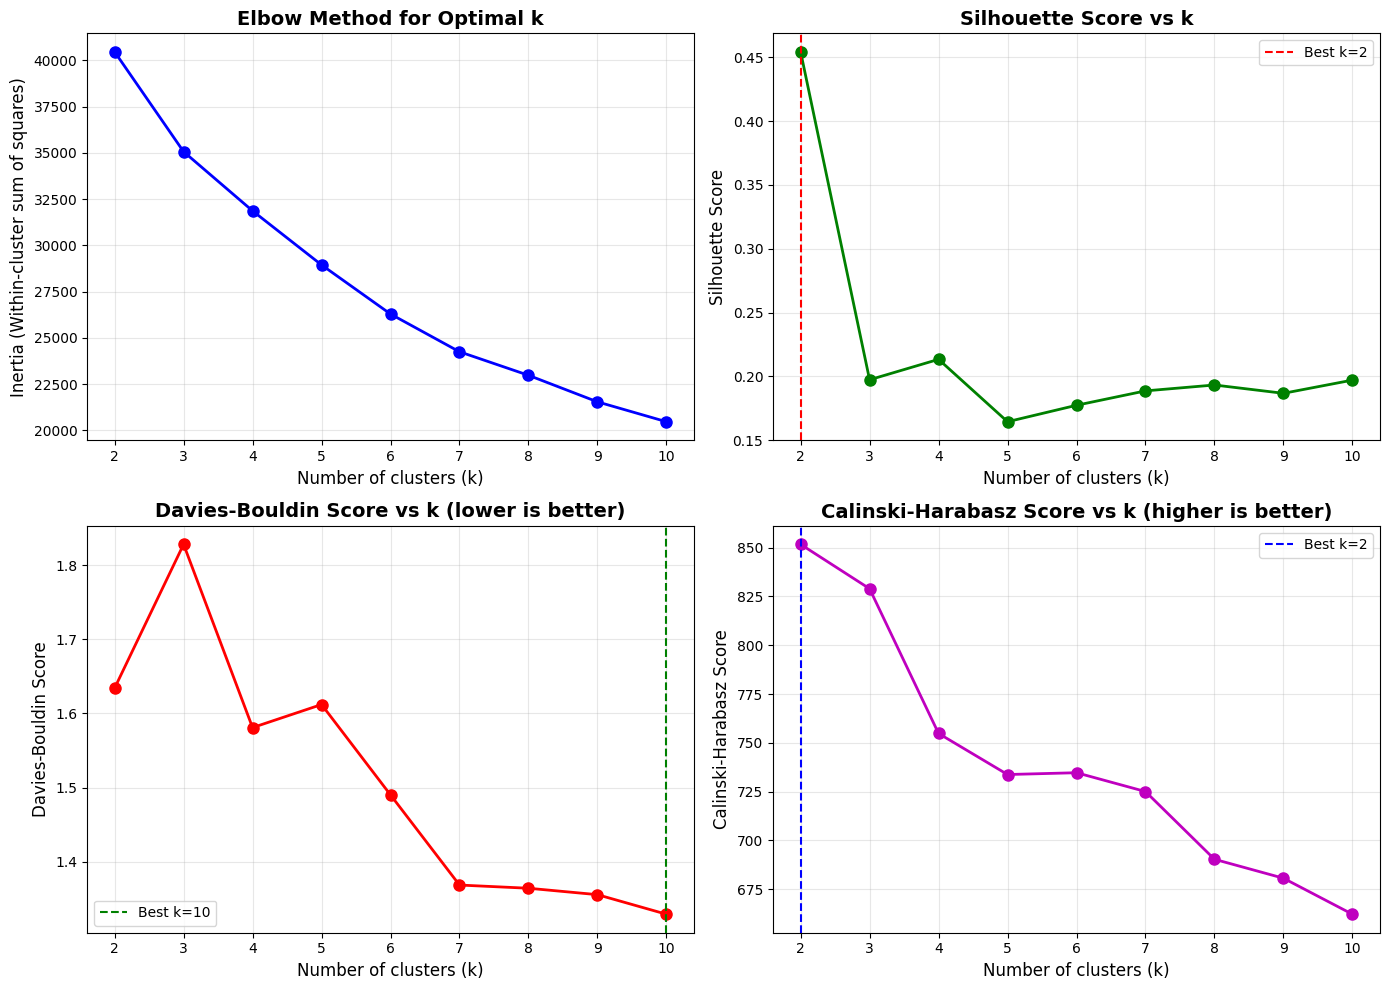


Best k based on Silhouette Score: 2
Best k based on Davies-Bouldin Score: 10
Best k based on Calinski-Harabasz Score: 2


In [4]:
# Visualize elbow method and evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow method
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score vs k', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
best_k_sil = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_sil, color='r', linestyle='--', label=f'Best k={best_k_sil}')
axes[0, 1].legend()

# Davies-Bouldin score (lower is better)
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Score vs k (lower is better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
best_k_db = k_range[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(x=best_k_db, color='g', linestyle='--', label=f'Best k={best_k_db}')
axes[1, 0].legend()

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score vs k (higher is better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
best_k_ch = k_range[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(x=best_k_ch, color='b', linestyle='--', label=f'Best k={best_k_ch}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(plots_dir / '2.1.1_k_selection_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest k based on Silhouette Score: {best_k_sil}")
print(f"Best k based on Davies-Bouldin Score: {best_k_db}")
print(f"Best k based on Calinski-Harabasz Score: {best_k_ch}")


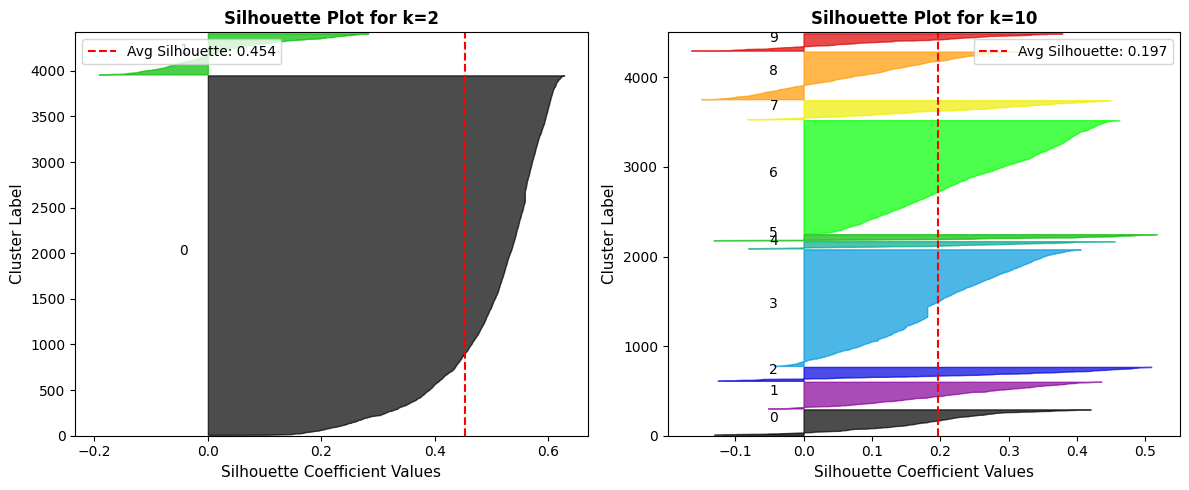

In [5]:
# Silhouette analysis for selected k values
selected_k_values = [best_k_sil, best_k_db, best_k_ch]
if len(set(selected_k_values)) < len(selected_k_values):
    selected_k_values = list(set(selected_k_values))

fig, axes = plt.subplots(1, len(selected_k_values), figsize=(6*len(selected_k_values), 5))

for idx, k in enumerate(selected_k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, labels)
    sample_silhouette_values = silhouette_samples(X_scaled, labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        axes[idx].fill_betweenx(np.arange(y_lower, y_upper),
                               0, ith_cluster_silhouette_values,
                               facecolor=color, edgecolor=color, alpha=0.7)
        
        axes[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    axes[idx].axvline(x=silhouette_avg, color="red", linestyle="--", 
                     label=f'Avg Silhouette: {silhouette_avg:.3f}')
    axes[idx].set_xlabel('Silhouette Coefficient Values', fontsize=11)
    axes[idx].set_ylabel('Cluster Label', fontsize=11)
    axes[idx].set_title(f'Silhouette Plot for k={k}', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, len(X_scaled) + (k + 1) * 10])
    axes[idx].legend()

plt.tight_layout()
plt.savefig(plots_dir / '2.1.1_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The silhouette coefficient ranges from **-1 to +1**:
- **+1**: Point is well-matched to its cluster and poorly matched to neighboring clusters (ideal)
- **0**: Point is on the boundary between two clusters (ambiguous)
- **-1**: Point is poorly matched to its cluster and better matched to a neighboring cluster (misclassified)

**What to Look For:**

1. **Average Silhouette Score (Red Dashed Line)**
   - Higher is better (closer to +1)
   - Values > 0.5 indicate good clustering structure
   - Values 0.3-0.5 indicate fair clustering
   - Values < 0.3 suggest poor clustering

2. **Cluster Width and Shape**
   - **Wide bars**: Most points in the cluster have high silhouette scores (good cohesion)
   - **Narrow bars**: Points have varying silhouette scores (less cohesive)
   - **Uniform width**: All clusters are similarly well-defined

3. **Cluster Heights**
   - Height represents the number of points in each cluster
   - Similar heights indicate balanced cluster sizes
   - Very different heights may indicate imbalanced clusters

4. **Negative Values**
   - Points with negative silhouette scores are closer to other clusters than their own
   - Many negative values suggest poor cluster separation
   - Ideally, all bars should be to the right of 0

5. **Comparing Different k Values**
   - Choose the k with the highest average silhouette score
   - Prefer k values where all clusters have mostly positive scores
   - Avoid k values with many negative scores or very low averages


## 2.1.2 Characterization of the Obtained Clusters

### Select optimal k and perform final clustering


In [6]:
# Manually override to try different Ks
optimal_k = 4
print(f"Selected optimal k: {optimal_k}")
print(f"Note: Chosen for patient profiling purposes (more nuanced patient stereotypes)")
print(f"  - Metrics-based best k (silhouette): {best_k_sil}")
print(f"  - Metrics-based best k (Davies-Bouldin): {best_k_db}")
print(f"  - Metrics-based best k (Calinski-Harabasz): {best_k_ch}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

# Save clustered data
df_clustered.to_csv(data_path / '2.1_kmeans_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.1_kmeans_clustered_data.csv'}")


Selected optimal k: 4
Note: Chosen for patient profiling purposes (more nuanced patient stereotypes)
  - Metrics-based best k (silhouette): 2
  - Metrics-based best k (Davies-Bouldin): 10
  - Metrics-based best k (Calinski-Harabasz): 2

Cluster distribution:
cluster
0    2487
1     306
2      83
3    1516
Name: count, dtype: int64

Clustered data saved to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/2.1_kmeans_clustered_data.csv


### How to Interpret the Cluster Centroids Comparison Plot

**What are Centroids?**
- Centroids represent the "average" or "typical" patient profile for each cluster
- Each centroid value shows the mean feature value for all patients in that cluster
- Values are in the **original scale** (not standardized), so they're interpretable in real-world units

**Reading the Plot:**

1. **X-axis (Features)**: Each bar position represents a different feature (e.g., n_lab_events, age, max_glucose)

2. **Y-axis (Feature Values)**: The height of each bar shows the centroid value for that feature
   - Higher bars = cluster has higher average values for that feature
   - Lower bars = cluster has lower average values for that feature
   - Bars near zero = cluster has values close to the overall dataset mean

3. **Colors (Clusters)**: Each color represents a different cluster
   - Compare how different clusters differ across features
   - Look for patterns: which clusters are similar? Which are distinct?

**What to Look For:**

1. **Distinctive Features per Cluster**
   - Find features where one cluster's bar is much higher/lower than others
   - These features help characterize and distinguish that cluster
   - Example: If Cluster 6 has a very high bar for "max_glucose", it represents patients with many diagnoses

2. **Cluster Similarities**
   - Clusters with similar bar patterns across features are similar patient types
   - Clusters with very different patterns represent distinct patient profiles

3. **Feature Patterns**
   - Look for features where clusters show clear separation (good for distinguishing clusters)
   - Features where all clusters are similar indicate less discriminatory power

4. **Clinical Interpretation**
   - Translate centroid values into patient characteristics:
     - High max_glucose → diabetic/metabolic issues
     - High n_lab_events → more intensive monitoring
     - High abnormal_ratio → more abnormal test results
     - High age → older patient population

**Example Interpretation:**
- If Cluster 4 has high bars for "n_lab_events", "n_micro_exam", and "abnormal_ratio", it might represent: *"Patients with extensive testing and many abnormal results - possibly complex cases requiring intensive monitoring"*
- If Cluster 0 has low bars across most features, it might represent: *"Relatively healthy patients with minimal testing and normal results"*


### Analysis of Cluster Centroids


Cluster Centroids (original scale):
           n_lab_events  n_micro_exam  total_procedures  n_diagnoses  \
Cluster 0         -0.48         -0.33             -0.20        -0.30   
Cluster 1          0.97          0.47              0.67         2.63   
Cluster 2          1.09          0.49              0.71         2.64   
Cluster 3          0.53          0.42              0.15        -0.18   

           n_positive_micro  abnormal_ratio  max_glucose  mean_creatinine  \
Cluster 0               0.0           -0.52        -0.31            -0.24   
Cluster 1               0.0            0.33         0.37             0.10   
Cluster 2               0.0            0.23         0.49             0.10   
Cluster 3               0.0            0.77         0.41             0.36   

           mean_hemoglobin   age  days_since_last_admission_x  \
Cluster 0             0.48 -0.11                         0.00   
Cluster 1            -0.20  0.06                        -0.45   
Cluster 2            -

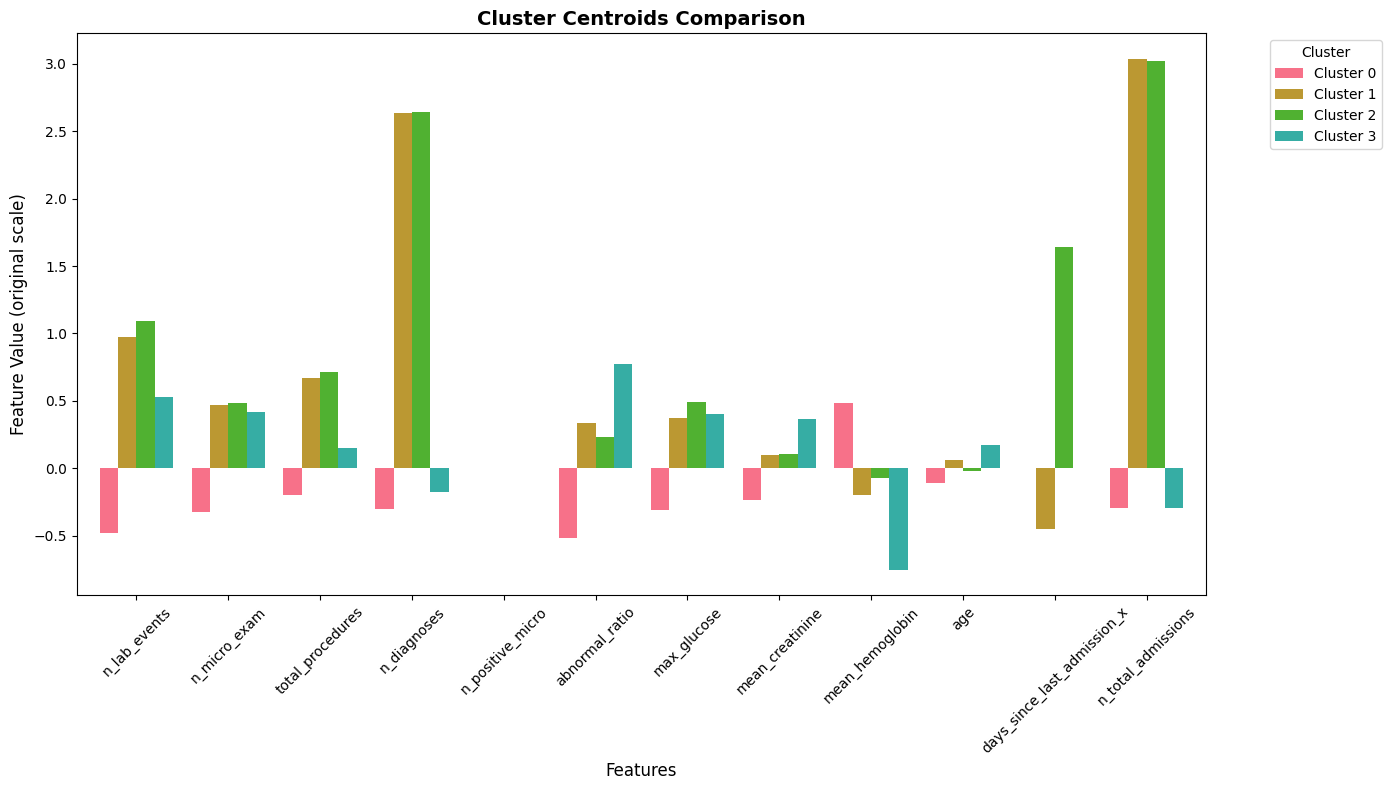

In [7]:
# Get centroids (in scaled space) and transform back to original scale
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Create dataframe with centroids
centroids_df = pd.DataFrame(centroids_original, columns=numeric_features)
centroids_df.index.name = 'cluster'
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("Cluster Centroids (original scale):")
print(centroids_df.round(2))

# Visualize centroids
fig, ax = plt.subplots(figsize=(14, 8))
centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Feature Value (original scale)', fontsize=12)
ax.set_title('Cluster Centroids Comparison', fontsize=14, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Comparison of Variable Distributions: Within Clusters vs Whole Dataset


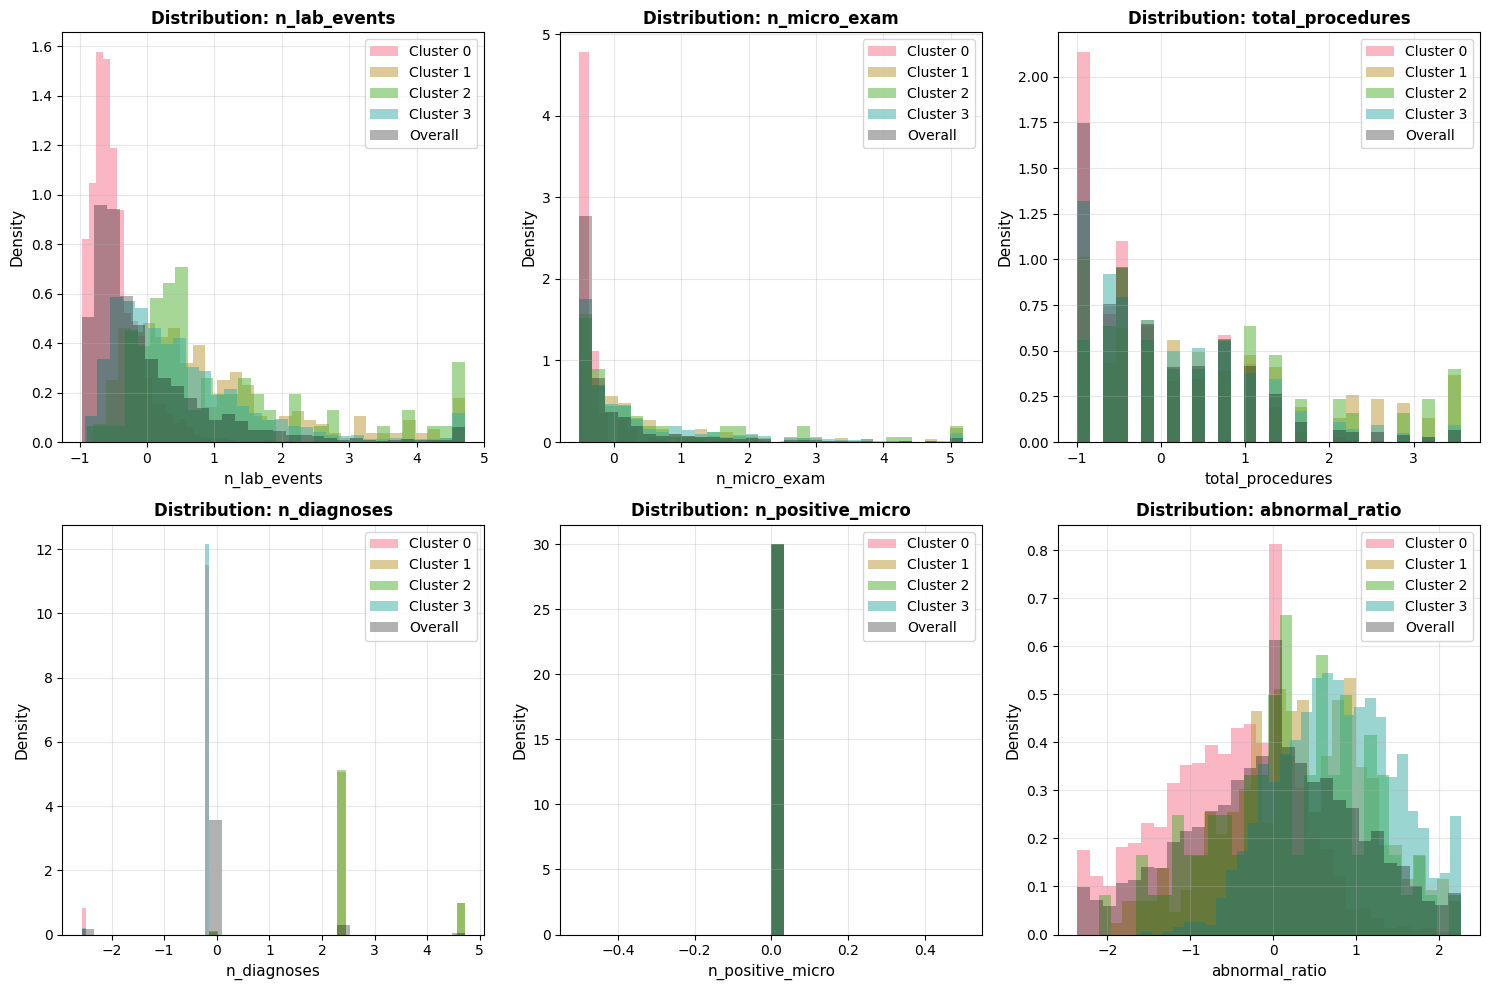

In [8]:
# Compare distributions for key features
key_features = numeric_features[:6]  # Select first 6 features for visualization

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot distribution for each cluster
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
    
    # Plot overall distribution
    ax.hist(df_clustered[feature], alpha=0.3, color='black', 
           label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


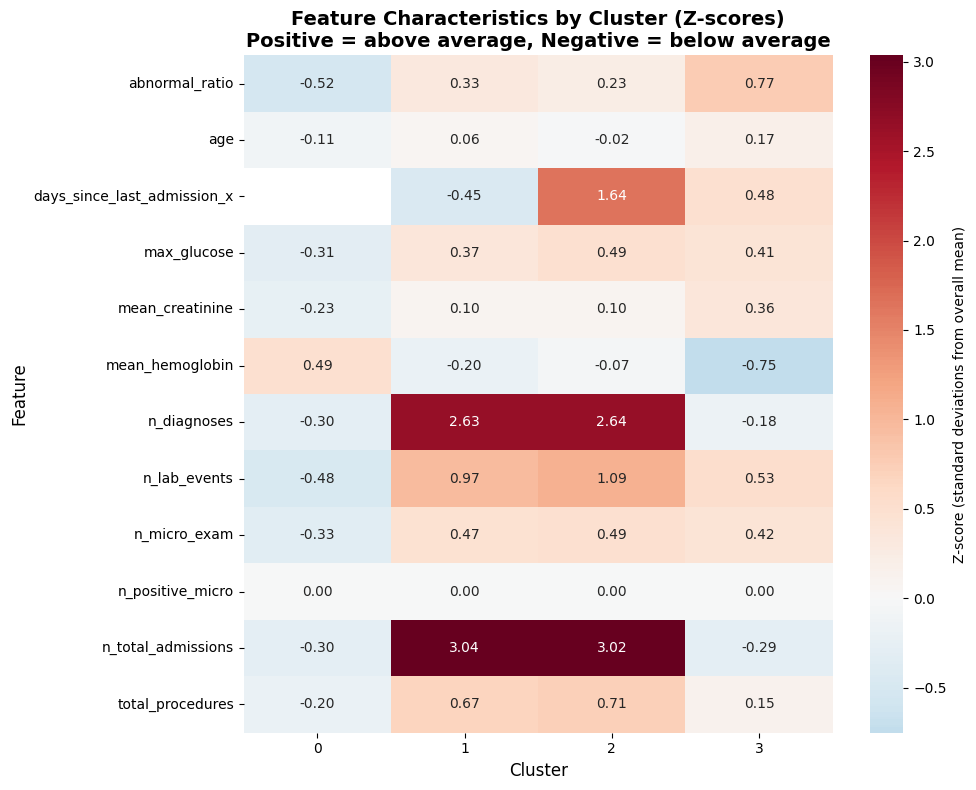


Cluster Characteristics Summary:
cluster
0    [{'feature': 'mean_hemoglobin', 'z_score': 0.4...
1    [{'feature': 'n_total_admissions', 'z_score': ...
2    [{'feature': 'n_total_admissions', 'z_score': ...
3    [{'feature': 'abnormal_ratio', 'z_score': 0.77...
dtype: object


In [9]:
# Statistical comparison: mean values per cluster vs overall mean
comparison_stats = []

for feature in numeric_features:
    overall_mean = df_clustered[feature].mean()
    overall_std = df_clustered[feature].std()
    
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        cluster_mean = cluster_data.mean()
        cluster_std = cluster_data.std()
        
        # Z-score: how many standard deviations away from overall mean
        z_score = (cluster_mean - overall_mean) / overall_std if overall_std > 0 else 0
        
        comparison_stats.append({
            'feature': feature,
            'cluster': cluster_id,
            'cluster_mean': cluster_mean,
            'cluster_std': cluster_std,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'difference': cluster_mean - overall_mean,
            'z_score': z_score
        })

comparison_df = pd.DataFrame(comparison_stats)

# Create heatmap of z-scores
pivot_z = comparison_df.pivot(index='feature', columns='cluster', values='z_score')

plt.figure(figsize=(10, max(8, len(numeric_features)*0.5)))
sns.heatmap(pivot_z, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           cbar_kws={'label': 'Z-score (standard deviations from overall mean)'})
plt.title('Feature Characteristics by Cluster (Z-scores)\nPositive = above average, Negative = below average', 
         fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_cluster_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCluster Characteristics Summary:")
print(comparison_df.groupby('cluster')[['feature', 'z_score']].apply(
    lambda x: x.nlargest(3, 'z_score')[['feature', 'z_score']].to_dict('records')
))


### 2D Visualization using PCA


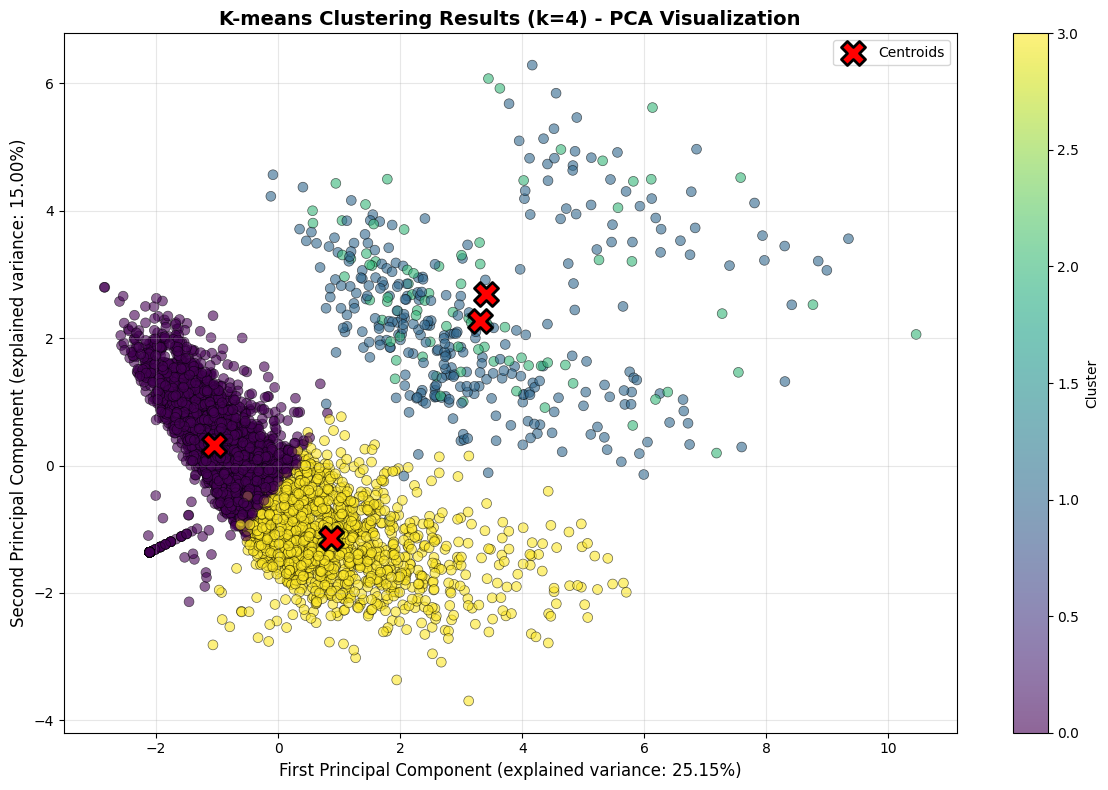

PCA explained variance ratio: [0.25148741 0.15001735]
Total explained variance: 40.15%


In [10]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                    cmap='viridis', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Plot centroids in PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
          c='red', marker='X', s=300, edgecolors='black', linewidth=2, 
          label='Centroids', zorder=10)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'K-means Clustering Results (k={optimal_k}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")


## 2.1.3 Evaluation of the Clustering Results


In [11]:
# Compute evaluation metrics
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
inertia = kmeans_final.inertia_

print("="*80)
print("K-MEANS CLUSTERING EVALUATION METRICS")
print("="*80)
print(f"Number of clusters (k): {optimal_k}")
print(f"\nSilhouette Score: {silhouette_avg:.4f}")
print("  (Range: -1 to 1, higher is better)")
print(f"\nDavies-Bouldin Score: {davies_bouldin:.4f}")
print("  (Range: 0 to ∞, lower is better)")
print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.4f}")
print("  (Range: 0 to ∞, higher is better)")
print(f"\nInertia (Within-cluster sum of squares): {inertia:.2f}")
print("  (Lower is better, but decreases with more clusters)")

# Create summary dataframe
evaluation_summary = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 
               'Calinski-Harabasz Score', 'Inertia'],
    'Value': [silhouette_avg, davies_bouldin, calinski_harabasz, inertia],
    'Interpretation': [
        f"{'Good' if silhouette_avg > 0.5 else 'Fair' if silhouette_avg > 0.3 else 'Poor'} clustering structure",
        f"{'Good' if davies_bouldin < 1 else 'Fair' if davies_bouldin < 2 else 'Poor'} cluster separation",
        f"Higher values indicate better defined clusters",
        f"Within-cluster variance"
    ]
})

print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)
print(evaluation_summary.to_string(index=False))


K-MEANS CLUSTERING EVALUATION METRICS
Number of clusters (k): 4

Silhouette Score: 0.2133
  (Range: -1 to 1, higher is better)

Davies-Bouldin Score: 1.5810
  (Range: 0 to ∞, lower is better)

Calinski-Harabasz Score: 754.8057
  (Range: 0 to ∞, higher is better)

Inertia (Within-cluster sum of squares): 31867.11
  (Lower is better, but decreases with more clusters)

EVALUATION SUMMARY
                 Metric        Value                                 Interpretation
       Silhouette Score     0.213300                      Poor clustering structure
   Davies-Bouldin Score     1.580965                        Fair cluster separation
Calinski-Harabasz Score   754.805737 Higher values indicate better defined clusters
                Inertia 31867.111632                        Within-cluster variance



CLUSTER SIZE ANALYSIS
Cluster 0: 2,487 subjects (56.6%)
Cluster 1: 306 subjects (7.0%)
Cluster 2: 83 subjects (1.9%)
Cluster 3: 1,516 subjects (34.5%)


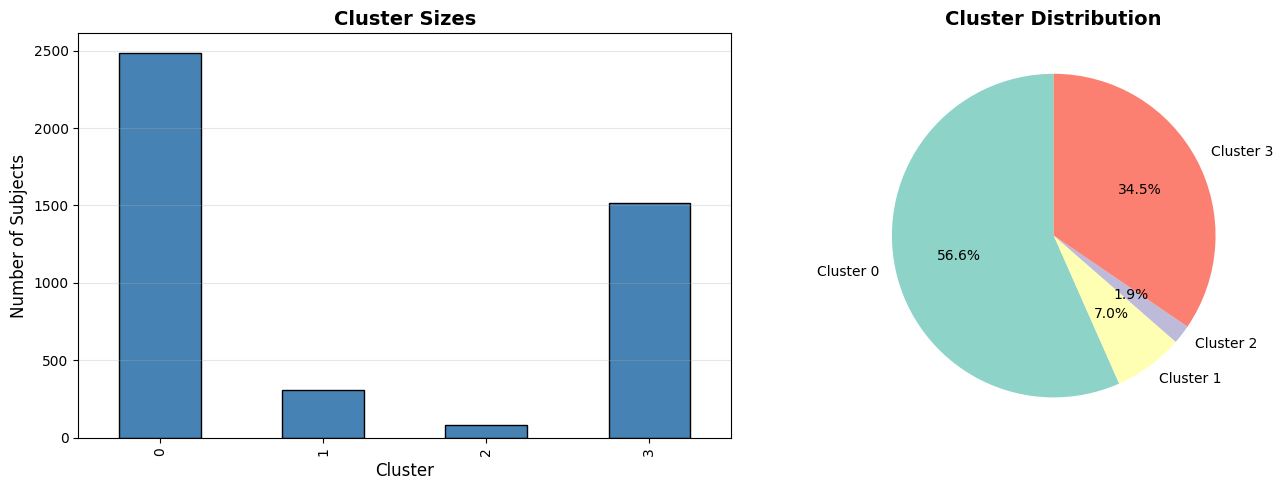

In [12]:
# Cluster size analysis
cluster_sizes = df_clustered['cluster'].value_counts().sort_index()
cluster_proportions = cluster_sizes / len(df_clustered)

print("\n" + "="*80)
print("CLUSTER SIZE ANALYSIS")
print("="*80)
for cluster_id in range(optimal_k):
    size = cluster_sizes[cluster_id]
    prop = cluster_proportions[cluster_id]
    print(f"Cluster {cluster_id}: {size:,} subjects ({prop:.1%})")

# Visualize cluster sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
cluster_sizes.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Number of Subjects', fontsize=12)
ax1.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Pie chart
ax2.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(optimal_k)], 
       autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
ax2.set_title('Cluster Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(plots_dir / '2.1.3_cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()
